In [26]:
import os
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import ToPILImage
from torchvision.models import alexnet, vgg11, vgg16, googlenet, inception_v3, resnet18, densenet161

from pcam import tqdm, get_dataloaders, train, test


In [27]:
## Check if GPU is used

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


### Model Selection

In [23]:
model_widget = widgets.Select(
    options=[('AlexNet', alexnet), ('VGG-16', vgg16), ('VGG-11', vgg11), ('GoogleNet', googlenet), ('Inception-v3', inception_v3), ('ResNet-18', resnet18), ('DenseNet-161', densenet161)],
    value=resnet18,
    description='Model:',
    disabled=False,
)
display(model_widget)

Select(description='Model:', index=5, options=(('AlexNet', <function alexnet at 0x7f6d25087e50>), ('VGG-16', <…

### Data Loading

In [11]:
## Data
batch_size = 32
train_loader, val_loader, test_loader = get_dataloaders('data', batch_size=batch_size, model_is_inception=(model_widget.value == inception_v3))


In [12]:
## Data Analysis (No need to run this)
# train_count, val_count, test_count = len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)
# train_cancer_count, val_cancer_count, test_cancer_count = 0, 0, 0

# for image, label in tqdm(train_loader):
#     train_cancer_count += torch.sum(label)
# for image, label in tqdm(val_loader):
#     val_cancer_count += torch.sum(label)
# for image, label in tqdm(test_loader):
#     test_cancer_count += torch.sum(label)
    

In [13]:
# print('Positive Class Percentage')
# print(f'   Train: {float(train_cancer_count/train_count * 100)}%')
# print(f'   Val: {float(val_cancer_count/val_count * 100)}%')
# print(f'   Test: {float(test_cancer_count/test_count * 100)}%')
# print(f'   Overall: {float((train_cancer_count+val_cancer_count+test_cancer_count)/(train_count+val_count+test_count) * 100)}%')


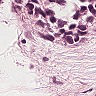

Label: 1


In [14]:
## Display an image from the dataset

id = 700
t = ToPILImage()
image, label = train_loader.dataset[id]
display(t(image))
print(f'Label: {label}')

### Initialization

In [ ]:
## Model
model = model_widget.value(pretrained=True)
model.to(device)
print(f'Selected Model: {model.__class__.__name__}')

# Freeze all layers except last
for param in model.parameters():
    param.requires_grad = False

# Create classification layer    
num_classes = 2
if model.__class__.__name__ in ['AlexNet', 'VGG']:
    model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
    params = model.classifier[-1].parameters()
else:
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    params = model.fc.parameters()


## Parameters
num_epochs = 5
num_classes = 2


## Optimizer
optimizer = torch.optim.Adam(params, lr=0.001)


## Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, epochs=num_epochs, steps_per_epoch=int(len(train_loader)/batch_size))


## Loss Function
loss_fun = torch.nn.CrossEntropyLoss()


### Training

In [18]:
train(model, train_loader, val_loader, loss_fun, optimizer, scheduler, num_epochs=num_epochs, num_classes=num_classes, device=device)

Epoch 1/5, Training: 100%|██████████| 8192/8192 [05:32<00:00, 24.66it/s]


4.00161477123387e-05


Epoch 1/5, Validation: 100%|██████████| 1024/1024 [00:34<00:00, 29.69it/s]


Train Loss: 0.4845, Train Acc: 0.7682, Train AUC: 0.7970, 
 Val Loss: 0.4381, Val Acc: 0.7939, Val AUC: 0.8394


Epoch 2/5, Training: 100%|██████████| 8192/8192 [05:25<00:00, 25.14it/s]


4.006458976290239e-05


Epoch 2/5, Validation: 100%|██████████| 1024/1024 [00:32<00:00, 31.46it/s]


Train Loss: 0.4313, Train Acc: 0.8024, Train AUC: 0.8456, 
 Val Loss: 0.4347, Val Acc: 0.7931, Val AUC: 0.8422


Epoch 3/5, Training: 100%|██████████| 8192/8192 [06:59<00:00, 19.53it/s]


4.014532289240628e-05


Epoch 3/5, Validation: 100%|██████████| 1024/1024 [00:32<00:00, 31.07it/s]


Train Loss: 0.4256, Train Acc: 0.8055, Train AUC: 0.8509, 
 Val Loss: 0.4321, Val Acc: 0.7932, Val AUC: 0.8472


Epoch 4/5, Training: 100%|██████████| 8192/8192 [05:05<00:00, 26.80it/s]


4.025834166895327e-05


Epoch 4/5, Validation: 100%|██████████| 1024/1024 [00:32<00:00, 31.86it/s]


Train Loss: 0.4224, Train Acc: 0.8071, Train AUC: 0.8538, 
 Val Loss: 0.4326, Val Acc: 0.7916, Val AUC: 0.8480


Epoch 5/5, Training: 100%|██████████| 8192/8192 [04:46<00:00, 28.58it/s]


4.040363848839871e-05


Epoch 5/5, Validation: 100%|██████████| 1024/1024 [00:33<00:00, 30.41it/s]

Train Loss: 0.4195, Train Acc: 0.8083, Train AUC: 0.8560, 
 Val Loss: 0.4331, Val Acc: 0.7934, Val AUC: 0.8486

Saved checkpoint at: models/ResNet_lr001_epoch5.pt


### Testing

In [25]:
# Use this line if you trained the model in the same session:
load_ckpt_path = os.path.join('models', f'{model.__class__.__name__}_lr{str(optimizer.defaults["lr"]).split(".")[1]}_epoch{num_epochs}.pt')
# Use this line if you want to load you own checkpoint manually:
# load_ckpt_path = 'models/VGG16_lr01_epoch5.pt'

test(model, test_loader, loss_fun, num_classes, device, load_ckpt_path=load_ckpt_path)

Testing: 100%|██████████| 1024/1024 [00:35<00:00, 29.20it/s]


GFLOPS: 0.6692, Test Loss: 0.4692, Test Acc: 0.7803, Test AUC: 0.8263
Saved results at: models/ResNet_lr001_epoch5.csv
